# **Customer Lifetime Value (CLV) Modeling**  

# i. Introduction

### Online Retail Transaction Analysis

Understanding customer value is critical for any data-driven retail business.  
Rather than treating all customers equally, effective decision-making depends on identifying which customers are likely to generate the most value over time.

This notebook presents an end-to-end Customer Lifetime Value (CLV) modeling workflow using historical transaction data from an online retail company. The analysis focuses on translating raw transactional records into meaningful customer-level insights that can support retention strategies, marketing prioritization, and long-term planning.

The work is structured to mirror a real-world analytical process — starting from data understanding and preparation, moving through feature engineering, and ending with predictive modeling and interpretation of results.

## Dataset Context

The analysis is based on the Online Retail II dataset from the UCI Machine Learning Repository, which contains transactional data from a UK-based non-store online retailer between 2009 and 2011.

The dataset records individual customer purchases at the invoice level, including timestamps, product information, quantities, prices, and customer identifiers. As is common in real-world transactional data, the dataset includes irregular purchase patterns, missing customer identifiers, and varying levels of customer engagement.

These characteristics make the dataset particularly suitable for modeling customer behavior over time and estimating Customer Lifetime Value using probabilistic approaches.

## Business Objective

The primary goal of this project is to estimate Customer Lifetime Value (CLV) by modeling both customer purchase frequency and monetary value based on historical behavior.

Specifically, this analysis aims to:
- Capture customer purchasing patterns using Recency, Frequency, and Monetary (RFM) features
- Predict future transaction behavior using probabilistic models
- Estimate expected customer value over a future horizon
- Segment customers based on predicted CLV to support data-driven retention and marketing decisions

The emphasis of this work is not only on model accuracy, but also on interpretability and practical usability in a business context.

## Analytical Approach

The CLV estimation in this notebook follows a structured, industry-standard workflow:

1. Data cleaning and preprocessing at the transaction level  
2. Customer-level feature engineering using RFM metrics  
3. Modeling purchase frequency with the BG/NBD model  
4. Modeling monetary value with the Gamma-Gamma model  
5. Estimating Customer Lifetime Value and interpreting the results  

Each step is designed to build incrementally toward a final CLV estimate that is both statistically sound and business-relevant.


# ii. Import Libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


# iii. Data Loading and Cleaning

## Data Loading

We load both yearly sheets and combine them into one dataset to build a continuous transaction history. This is important for CLV, since customer value is measured over time and shouldn’t be split across separate files.

In [25]:
# Load xls file
xls = pd.ExcelFile("online_retail_II.xlsx")

# Check sheet names
xls.sheet_names

['Year 2009-2010', 'Year 2010-2011']

In [26]:
# Load sheets

df_2009 = pd.read_excel(
    "online_retail_II.xlsx", 
    sheet_name="Year 2009-2010"
)

df_2010 = pd.read_excel(
    "online_retail_II.xlsx", 
    sheet_name="Year 2010-2011"
)

In [27]:
# Concat data
df = pd.concat([df_2009, df_2010], ignore_index=True)

## Check Data Type

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779425 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  object        
 1   StockCode    779425 non-null  object        
 2   Description  779425 non-null  object        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  float64       
 7   Country      779425 non-null  object        
 8   Revenue      779425 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 59.5+ MB


## Data Validation

### Validation of Quantity

Transactions with zero or negative quantities typically represent cancellations, returns, or data issues. Since CLV aims to capture realized customer value, we exclude these records to avoid biasing spending and purchase behavior metrics.

In [ ]:
# Check invalid quantity
(df["Quantity"] <= 0).sum()

22950

In [ ]:
# Clean invalid quantity from dataset
df = df[df["Quantity"] > 0]

### Validation of Price

Prices that are zero or negative are not meaningful for revenue-based analysis and can distort monetary estimates. We filter them out to keep only valid commercial transactions.

In [31]:
# Check invalid price
(df["Price"] <= 0).sum()

2750

In [32]:
# Clean invalid price
df = df[df["Price"] > 0]

### Validation of Customer ID 

CLV is calculated at the customer level, so transactions without a customer identifier can’t be attributed to any individual customer. We remove these rows because they can’t be used for retention, frequency, or value estimation.

In [34]:
# Clear invalid customer ID
df = df.dropna(subset=["Customer ID"])

### Check InvoiceDate Sanity

We verify the date range to confirm the dataset covers the expected time period and does not contain obvious timestamp anomalies. This matters because snapshot date selection, recency, and tenure all depend on reliable transaction timestamps.

In [36]:
df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

### Create Revenue Column

We create a revenue field (Quantity × Price) as a core business variable representing the monetary value of each line item. Feature engineering and CLV modeling are built on top of this validated revenue measure.

In [39]:
df["Revenue"] = df["Quantity"] * df["Price"]

### Remove Duplicated Rows

Duplicate rows can lead to double-counting purchases and inflating customer value metrics. We drop exact duplicates to keep each transaction line represented only once.

In [37]:
df.duplicated().sum()

26124

In [38]:
# Drop duplicated rows
df = df.drop_duplicates()

## Cast Customer ID's Type

Customer IDs are first cast to integers to remove decimal artifacts introduced by missing values, and then converted to strings. This ensures that customer identifiers are treated as categorical labels rather than numeric values, preventing unintended numerical operations and avoiding grouping or joining inconsistencies caused by float representations

In [ ]:
df['Customer ID'] = df['Customer ID'].astype(int).astype(str)

## Year Distribution Check 

We examine the distribution of transactions by year to confirm that the data falls within a consistent and expected time range. This helps identify potential timestamp anomalies and ensures that customer activity is properly aligned for recency, tenure, and CLV calculations.

In [57]:
df['InvoiceDate'].dt.year.value_counts().sort_index()

InvoiceDate
2009     30272
2010    382130
2011    367023
Name: count, dtype: int64

## Cancellation Check

We additionally checked for cancelled invoices, which are commonly indicated by invoice numbers starting with the letter “C”. This serves as a secondary validation to ensure that no cancellation records remain after quantity-based filtering.

In [50]:
df['Invoice'].astype(str).str.startswith('C').sum()

0

## Outlier Describe

We examined high-end percentiles (95th, 99th, and 99.9th) for quantity, price, and revenue to identify extreme values that could disproportionately influence CLV estimates. This step helps distinguish between legitimate high-value customers and potential data anomalies.

In [51]:
df[['Quantity','Price','Revenue']].describe(percentiles=[.95,.99,.999])

,Quantity,Price,Revenue
count,779425.000000,779425.000000,779425.000000
mean,13.489370,3.218488,22.291823
std,145.855814,29.676140,227.427075
min,1.000000,0.001000,0.001000
50%,6.000000,1.950000,12.480000
95%,36.000000,8.500000,67.500000
99%,144.000000,14.950000,203.520000
99.9%,576.000000,49.950000,864.000000
max,80995.000000,10953.500000,168469.600000


The distribution of quantity, price, and revenue is heavily right-skewed, with a small proportion of transactions contributing disproportionately to total revenue. While these extreme values may represent legitimate high-volume purchases, they can strongly influence average-based CLV estimates. Therefore, they are carefully examined and treated separately in downstream modeling.

## Summary

The dataset was consolidated from two yearly transaction files to form a continuous customer purchase history suitable for CLV analysis. A series of business-driven validation steps were applied to ensure data integrity, including the removal of cancelled or invalid transactions (non-positive quantities and prices), exclusion of records without customer identifiers, and elimination of duplicate rows to prevent double-counting.

Transaction timestamps were validated to confirm a consistent and expected time range, providing a reliable foundation for recency and tenure calculations. Customer identifiers were standardized to categorical labels to avoid numerical misinterpretation in downstream analysis.

Finally, revenue was constructed as a core business variable, and high-end percentiles of quantity, price, and revenue were examined to understand the presence and impact of extreme values. These steps ensure that subsequent exploratory analysis and CLV modeling are based on clean, interpretable, and business-relevant data.

# iv. Exploratory Data Analysis

## Customer Landscape

In this step, we map the basic “shape” of the customer base: how many unique customers exist, how many transactions each customer makes, and how concentrated activity is across customers. This matters because CLV is fundamentally a customer-level concept—if most customers purchase only once, the business behaves more like one-off retail and CLV modeling becomes harder (or less meaningful). On the other hand, if repeat behavior is common, we have a stronger foundation to model retention, frequency, and future value. This customer landscape also guides modeling choices later (e.g., whether we need segmentation, whether the distribution is heavy-tailed, and whether robust metrics like medians are more reliable than averages).

In [61]:
# Basic dataset footprint
n_rows = len(df)
n_customers = df["Customer ID"].nunique()
n_invoices = df["Invoice"].nunique()

print(f"Rows (transaction lines): {n_rows:,}")
print(f"Unique customers: {n_customers:,}")
print(f"Unique invoices: {n_invoices:,}")


Rows (transaction lines): 779,425
Unique customers: 5,878
Unique invoices: 36,969


In [83]:
# Transaction per customer (invoice lines)
tx_per_customer = df.groupby("Customer ID").size().rename("txn_lines")

# Invoive per customer
invoices_per_customer = df.groupby("Customer ID")["Invoice"].nunique().rename("invoices")

# Quick distributuion summary
summary_txn_lines = tx_per_customer.describe(percentiles=[.5, .75, .9, .95, .99]).to_frame()
summary_invoices = invoices_per_customer.describe(percentiles=[.5, .75, .9, .95, .99]).to_frame()

# Preview
display(summary_txn_lines)
display(summary_invoices)

,txn_lines
count,5878.000000
mean,132.600374
std,342.190092
min,1.000000
50%,52.000000
75%,138.000000
90%,309.000000
95%,481.150000
99%,1065.840000
max,12435.000000


,invoices
count,5878.000000
mean,6.289384
std,13.009406
min,1.000000
50%,3.000000
75%,7.000000
90%,13.000000
95%,21.000000
99%,46.000000
max,398.000000


In [74]:
# repeat vs one-time customers (based on invoices)
one_time_cust = (invoices_per_customer == 1).sum()
repeat_cust = (invoices_per_customer > 1).sum()
one_time_share = one_time_cust / n_customers
repeat_share = repeat_cust / n_customers

# Prview
print(f"One-time customers (1 invoice): {one_time_cust:,} ({one_time_share:.1%})")
print(f"Repeat customers (>1 invoice): {repeat_cust:,} ({repeat_share:.1%})")


One-time customers (1 invoice): 1,623 (27.6%)
Repeat customers (>1 invoice): 4,255 (72.4%)


In [76]:
# Check the number of activity comes from top customers
top_1pct = int(round(n_customers * 0.01))
top_5pct = int(round(n_customers * 0.05))

txn_sorted = tx_per_customer.sort_values(ascending=False)
share_top_1pct = txn_sorted.head(top_1pct).sum() / txn_sorted.sum()
share_top_5pct = txn_sorted.head(top_5pct).sum() / txn_sorted.sum()

print(f"Share of txn lines from top 1% customers: {share_top_1pct:.1%}")
print(f"Share of txn lines from top 5% customers: {share_top_5pct:.1%}")


Share of txn lines from top 1% customers: 17.1%
Share of txn lines from top 5% customers: 38.0%


In [77]:
# Show top customers ny revenue
rev_per_customer = df.groupby('Customer ID')['Revenue'].sum().sort_values(ascending=False)
display(rev_per_customer.head(10).to_frame('total_revenue'))

,total_revenue
Customer ID,
18102,580987.04
14646,528602.52
14156,313437.62
14911,291420.81
17450,244784.25
13694,195640.69
17511,172132.87
16446,168472.50
16684,147142.77


---
**Customer Landscape Summary**

---

The dataset contains 5,878 unique customers generating 36,969 purchase occasions across 779,425 invoice lines, indicating a relatively large and active customer base. Customer behavior shows a strong tendency toward repeat purchasing, with approximately 72% of customers making more than one purchase, suggesting that CLV modeling is meaningful and retention-driven rather than purely transactional.

Activity and value are unevenly distributed across customers. While the median customer makes a small number of purchases, a long right tail exists, where a small fraction of customers contributes disproportionately to total transaction volume and revenue. The top 5% of customers alone account for nearly 40% of all transaction lines, highlighting the presence of high-engagement, high-value customers.

These patterns indicate a classic long-tail retail structure, where most customers exhibit low-to-moderate activity, while a small segment drives a substantial share of business value. This has direct implications for downstream CLV modeling, suggesting the need for robust metrics, potential segmentation, and careful handling of extreme customer behavior to avoid biased lifetime value estimates.

## Revenue Consentration and Value Distribution

In this step, we measure how revenue is distributed across customers—whether value is broadly shared or heavily driven by a small group. This matters because CLV is often influenced by a long-tail structure: many customers contribute modestly, while a small “VIP” segment accounts for a disproportionate share of total revenue. Understanding this concentration helps us interpret CLV outputs responsibly and choose modeling strategies that won’t be distorted by extreme customers. It also guides practical business decisions later, such as whether to treat high-value customers as a separate segment, use robust metrics (median, percentiles) rather than averages, or apply caps/log transforms to stabilize modeling.

In [87]:
# Revenue per customer
rev_per_customer = (
    df.groupby("Customer ID")["Revenue"]
      .sum()
      .sort_values(ascending=False)
)

# Basic distribution summary
rev_summary = rev_per_customer.describe(percentiles=[.5, .75, .9, .95, .99, .995, .999])
display(rev_summary.to_frame("revenue_per_customer"))

,revenue_per_customer
count,5878.000000
mean,2955.904095
std,14440.852688
min,2.950000
50%,867.740000
75%,2248.305000
90%,5465.741000
95%,9374.227000
99%,29205.901000
99.5%,55093.963750


In [88]:
# Share of revenue by top x% customers
n_customers = rev_per_customer.shape[0]

def top_share(series, pct):
    k = max(1, int(round(len(series) * pct)))
    return series.head(k).sum() / series.sum()

share_top_1pct  = top_share(rev_per_customer, 0.01)
share_top_5pct  = top_share(rev_per_customer, 0.05)
share_top_10pct = top_share(rev_per_customer, 0.10)
share_top_20pct = top_share(rev_per_customer, 0.20)

print(f"Revenue share - Top 1% customers : {share_top_1pct:.1%}")
print(f"Revenue share - Top 5% customers : {share_top_5pct:.1%}")
print(f"Revenue share - Top 10% customers: {share_top_10pct:.1%}")
print(f"Revenue share - Top 20% customers: {share_top_20pct:.1%}")

Revenue share - Top 1% customers : 32.0%
Revenue share - Top 5% customers : 52.0%
Revenue share - Top 10% customers: 63.9%
Revenue share - Top 20% customers: 77.2%


In [89]:
# Pareto-style checkpoint: what % of customers drive 80% revenue?
cum_share = (rev_per_customer.cumsum() / rev_per_customer.sum())
pct_customers_for_80 = (cum_share <= 0.80).mean()  # proportion of customers still under 80%
# Add 1 customer margin because threshold crossing happens right after
pct_customers_for_80 = min(1.0, pct_customers_for_80 + (1 / n_customers))

print(f"Approx. % customers needed to reach 80% revenue: {pct_customers_for_80:.1%}")

Approx. % customers needed to reach 80% revenue: 23.0%


In [92]:
# Compare mean vs median (skew indicator)
mean_rev = rev_per_customer.mean()
median_rev = rev_per_customer.median()
print(f"Mean revenue/customer  : {mean_rev:,.2f}")
print(f"Median revenue/customer: {median_rev:,.2f}")

Mean revenue/customer  : 2,955.90
Median revenue/customer: 867.74


---
**Revenue Consentration and Value Distribution**

---

The revenue distribution across customers is highly concentrated and strongly right-skewed, indicating that a relatively small segment of customers drives a disproportionate share of total business value. While the average revenue per customer is approximately £2,956, the median revenue is only £868, which clearly shows that the “typical” customer spends far less than what the mean suggests. This gap confirms the presence of a long-tail structure where a small number of high-value customers significantly inflate average-based metrics.

This concentration becomes even more evident when examining revenue shares by customer segments. The top 1% of customers alone account for roughly 32% of total revenue, while the top 5% contribute more than half of overall revenue. Expanding further, the top 20% of customers are responsible for over 77% of total revenue, closely aligning with a Pareto-like pattern. In practical terms, this means that business performance is heavily dependent on a relatively small group of customers, and losing even a fraction of this segment could materially impact revenue.

The Pareto checkpoint reinforces this insight: approximately 23% of customers are sufficient to generate 80% of total revenue. This confirms that the customer base is not value-homogeneous and that treating all customers as equal in downstream modeling would be misleading. High-revenue customers are not just statistical outliers—they represent a structurally important segment of the business.

From a CLV modeling perspective, these findings have direct implications. First, relying solely on mean-based CLV estimates would overstate the expected value of the majority of customers. Second, the presence of extreme high-value customers suggests the need for robust modeling choices, such as segmentation, log-transformed targets, or capped metrics, to ensure stability and interpretability. Finally, this concentration highlights an opportunity from a business standpoint: targeted retention and engagement strategies for high-value customers are likely to deliver outsized returns compared to uniform customer treatment.

Overall, this step confirms that CLV modeling is both relevant and necessary, but it must be approached with an awareness of strong revenue concentration to avoid biased estimates and to reflect the true economic structure of the customer base.

## Frequency Behaviour

In this step, we look at purchase frequency—how often customers come back and place orders. For CLV, frequency is a core driver of lifetime value: two customers with similar total revenue today can have very different future value depending on whether they purchase regularly or only once in a while. By understanding the frequency distribution, we can separate one-time buyers from repeat customers, identify the “core” segment that shows steady buying habits, and spot heavy repeaters who may behave differently from the rest. This also directly informs modeling choices later, such as whether to treat frequency as a count process, apply segmentation, or reduce skew with transformations so the model isn’t dominated by a small group of extreme customers.

In [94]:
# Purchases (invoices) per customer = frequency
invoices_per_customer = (
    df.groupby("Customer ID")["Invoice"]
      .nunique()
      .rename("n_invoices")
)

# Distribution summary (focus on tail)
freq_summary = invoices_per_customer.describe(percentiles=[.5, .75, .9, .95, .99, .995, .999])
display(freq_summary.to_frame("invoices_per_customer"))

,invoices_per_customer
count,5878.000000
mean,6.289384
std,13.009406
min,1.000000
50%,3.000000
75%,7.000000
90%,13.000000
95%,21.000000
99%,46.000000
99.5%,68.230000


In [95]:
# Share of customers by frequency buckets
freq_bins = pd.cut(
    invoices_per_customer,
    bins=[0, 1, 2, 5, 10, 20, 50, float("inf")],
    labels=["1", "2", "3–5", "6–10", "11–20", "21–50", "51+"],
    right=True
)

freq_bucket_share = (
    freq_bins.value_counts(normalize=True)
             .sort_index()
             .rename("share")
             .to_frame()
)

freq_bucket_share["customers"] = freq_bins.value_counts().sort_index()
display(freq_bucket_share)

,share,customers
n_invoices,,
1,0.276114,1623
2,0.160599,944
3–5,0.256890,1510
6–10,0.157366,925
11–20,0.098503,579
21–50,0.041341,243
51+,0.009187,54


In [96]:
# Repeat rate
one_time = (invoices_per_customer == 1).sum()
repeat = (invoices_per_customer > 1).sum()
n_customers = invoices_per_customer.shape[0]

print(f"One-time customers (1 invoice): {one_time:,} ({one_time/n_customers:.1%})")
print(f"Repeat customers (>1 invoice):  {repeat:,} ({repeat/n_customers:.1%})")


One-time customers (1 invoice): 1,623 (27.6%)
Repeat customers (>1 invoice):  4,255 (72.4%)


In [98]:
# Contribution to total invoices: do heavy repeaters dominate purchase occasions?
inv_sorted = invoices_per_customer.sort_values(ascending=False)

def top_share(series, pct):
    k = max(1, int(round(len(series) * pct)))
    return series.head(k).sum() / series.sum()

share_invoices_top_1pct = top_share(inv_sorted, 0.01)
share_invoices_top_5pct = top_share(inv_sorted, 0.05)
share_invoices_top_10pct = top_share(inv_sorted, 0.10)

print(f"Invoice share - Top 1% customers : {share_invoices_top_1pct:.1%}")
print(f"Invoice share - Top 5% customers : {share_invoices_top_5pct:.1%}")
print(f"Invoice share - Top 10% customers: {share_invoices_top_10pct:.1%}")


Invoice share - Top 1% customers : 15.4%
Invoice share - Top 5% customers : 33.9%
Invoice share - Top 10% customers: 47.0%


In [113]:
#  List extreme repeaters
display(inv_sorted.head(10).to_frame("n_invoices"))

,n_invoices
Customer ID,
14911,398
12748,336
17841,211
15311,208
13089,203
14606,192
14156,156
17850,155
14646,151


---
**Summary of Frequency Behaviour**

---

This frequency analysis shows a customer base that is clearly repeat-driven, but also highly skewed.

Most customers make only a handful of purchases: the median customer places 3 invoices, and even at the 75th percentile, customers only reach 7 invoices. This tells us that “light repeaters” dominate the population. However, the long tail is very real. A small group of customers places dozens, even hundreds of invoices, with the maximum reaching 398 invoices.

The frequency distribution confirms that customer behavior is not uniform. Roughly 72% of customers are repeat buyers, but repeat behavior is highly uneven. A very small fraction of customers generates a disproportionately large share of total purchase occasions. For example, the top 10% of customers already account for 47% of all invoices, while the top 1% alone contributes more than 15%.

From a modeling perspective, this strongly supports the use of frequency-aware CLV models (such as BG/NBD-style approaches). It also signals that simple averages would be misleading: the “average customer” does not actually exist in this dataset. Instead, CLV will be driven by the model’s ability to separate casual repeaters from true heavy buyers.

## Temporal Behavior and Seasonality

In this step, we analyze when customers transact, not just how much or how often. Temporal behavior helps us understand purchase timing patterns, seasonal demand, and customer lifecycle dynamics.

For CLV modeling, time is critical. Recency, frequency, and monetary value only make sense when anchored to reliable temporal signals. Seasonality can distort short-term revenue, inflate frequency during peak periods, or create false churn signals during off-seasons. Without understanding these patterns, a CLV model may incorrectly interpret normal seasonal inactivity as customer churn.

By examining transaction trends over time—monthly volume, revenue seasonality, and customer activity—we ensure that downstream models correctly separate behavioral change from calendar-driven effects. This allows CLV predictions to reflect true customer intent rather than temporary seasonal noise.

### Transaction & Revenue Trend Over Time (Monthly)

In [117]:
# Create year-month column
df["year_month"] = df["InvoiceDate"].dt.to_period("M")

# Monthly transaction count (invoices)
monthly_invoices = (
    df.groupby("year_month")["Invoice"]
    .nunique()
    .rename("n_invoices")
)

# Monthly revenue
monthly_revenue = (
    df.groupby("year_month")["Revenue"]
    .sum()
    .rename("total_revenue")
)

# Combine into one table
monthly_trends = pd.concat([monthly_invoices, monthly_revenue], axis=1)

display(monthly_trends.head())

,n_invoices,total_revenue
year_month,,
2009-12,1512,683504.010
2010-01,1011,555802.672
2010-02,1104,504558.956
2010-03,1524,696978.471
2010-04,1329,591982.002


### Seasonality by Month of Year

In [118]:
# Extract month number
df["month"] = df["InvoiceDate"].dt.month

# Monthly seasonality (average across years)
monthly_seasonality = (
    df.groupby("month")
    .agg(
        avg_revenue=("Revenue", "mean"),
        total_revenue=("Revenue", "sum"),
        n_invoices=("Invoice", "nunique")
    )
)

display(monthly_seasonality)

,avg_revenue,total_revenue,n_invoices
month,,,
1,26.478443,1123903.982,1998
2,22.239365,950643.876,2101
3,22.012212,1291060.231,2845
4,21.523959,1060356.333,2478
5,22.647471,1275188.530,2932
6,22.501774,1296417.180,2890
7,22.334312,1188699.071,2712
8,23.595215,1246275.640,2573
9,24.116213,1779704.153,3444


### Customer Activity Over Time

In [123]:
# Active customers per month
monthly_active_customers = (
    df.groupby("year_month")["Customer ID"]
    .nunique()
    .rename("active_customers")
)

display(monthly_active_customers.head())

year_month
2009-12     955
2010-01     720
2010-02     772
2010-03    1057
2010-04     942
Freq: M, Name: active_customers, dtype: int64

---

**Summary of Temporal Behaviour and Seasonality**

---

This temporal analysis reveals that customer activity and revenue are not evenly distributed over time, and that seasonality plays a meaningful role in shaping purchasing behavior.

On a monthly trend level, both invoice volume and revenue fluctuate throughout the year rather than following a smooth linear pattern. Certain months consistently show higher transaction intensity and revenue contribution, indicating periods of elevated commercial activity. This suggests that customer engagement is influenced by external temporal factors such as seasonal demand, budgeting cycles, or promotional calendars.

When we aggregate behavior by calendar month across years, a clear seasonal pattern emerges. Late-year months—especially October to December—stand out with significantly higher invoice counts and total revenue, while average revenue per transaction remains relatively stable. This indicates that seasonality in this business is driven primarily by higher purchase frequency, not by customers spending more per transaction.

Customer activity over time further confirms this pattern. The number of active customers varies meaningfully from month to month, peaking during high-season periods and softening during early-year months. This temporal unevenness matters for CLV because recency, frequency, and future purchase probability are all time-dependent. Ignoring seasonality would risk misinterpreting customer inactivity during low-season months as churn.

From a modeling perspective, these findings justify the use of a well-defined snapshot date, careful interpretation of recency metrics, and caution against naive churn assumptions. Customers may appear “inactive” simply because they are in a low-demand season, not because they have disengaged from the business.

## Recency & Customer Activity State

In this step, we measure how recently each customer has purchased and translate that into a simple, business-friendly view of customer health: who is still active, who is drifting, and who is likely churning. Recency matters because CLV is not just about how much someone has spent in the past—it's about how likely they are to purchase again in the future. Two customers can have similar total revenue, but if one purchased last week and the other last purchased a year ago, their expected future value is fundamentally different.

We’ll define a snapshot date (a fixed “as of” date) and compute each customer’s last purchase date and recency in days. Then we’ll build activity states using time thresholds (e.g., Active / Warm / Sleeping / At-risk). This helps us: (1) validate whether the dataset supports meaningful CLV modeling, (2) avoid confusing seasonal inactivity with churn, and (3) create features that are directly predictive for downstream modeling.

In [ ]:
# Create snapshot date: one day after the last transaction date
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Last purchase and recency of customers
cust_last = (
    df.groupby("Customer ID")["InvoiceDate"]
      .max()
      .rename("last_purchase_date")
      .to_frame()
)

cust_last["recency_days"] = (snapshot_date - cust_last["last_purchase_date"]).dt.days

# Quick recency distribution (focus on tail) 
recency_summary = cust_last["recency_days"].describe(percentiles=[.5, .75, .9, .95, .99])
display(recency_summary.to_frame("recency_days"))

,recency_days
count,5878.000000
mean,201.331916
std,209.338707
min,1.000000
50%,96.000000
75%,380.000000
90%,535.000000
95%,625.000000
99%,726.000000
max,739.000000


In [130]:
# Activity state classification (business-friendly buckets)
bins = [-1, 30, 90, 180, 365, np.inf]
labels = ["Active (<=30d)", "Warm (31-90d)", "Sleeping (91-180d)", "At-risk (181-365d)", "Dormant (>365d)"]

cust_last["activity_state"] = pd.cut(
    cust_last["recency_days"],
    bins=bins,
    labels=labels
)

# Share of customers by state
state_share = (
    cust_last["activity_state"]
      .value_counts(normalize=True)
      .sort_index()
      .rename("share")
      .to_frame()
)

state_share["customers"] = (
    cust_last["activity_state"]
      .value_counts()
      .sort_index()
)

display(state_share)

,share,customers
activity_state,,
Active (<=30d),0.280367,1648
Warm (31-90d),0.211126,1241
Sleeping (91-180d),0.100204,589
At-risk (181-365d),0.134570,791
Dormant (>365d),0.273733,1609


---
**Summary of Recency and Customer Activity State

---

This analysis examines how recently customers last interacted with the business, which is one of the most critical signals in any CLV framework. Recency captures the freshness of the customer relationship and strongly influences both future purchase probability and churn risk.

Using a snapshot date set immediately after the last observed transaction ensures that recency is measured consistently across all customers. The distribution shows a highly right-skewed pattern: while the median customer last purchased about 96 days ago, a substantial portion of customers has been inactive for much longer periods. Nearly a quarter of customers fall into the Dormant (>365 days) category, while only about 28% are truly Active (≤30 days).

This split highlights a business reality where the customer base is structurally heterogeneous. The business simultaneously manages fresh, engaged customers and a large backlog of long-inactive ones. Importantly, inactivity here does not automatically imply churn—especially given the seasonal patterns identified earlier—but it does signal lower short-term purchase probability.

From a modeling standpoint, this validates recency as a primary driver feature rather than a simple descriptive metric. CLV models must differentiate between customers who are temporarily inactive (Warm or Sleeping) and those who are structurally disengaged (Dormant). Treating all inactivity as churn would significantly undervalue a meaningful portion of the customer base.

## Customers Tenure and Lifecycle Length

Customer tenure measures how long a customer relationship lasts, from the first recorded purchase to the most recent one. While recency tells us how fresh the relationship is, tenure explains how durable it has been over time. Together, these two dimensions distinguish new customers, short-lived buyers, and long-standing loyal customers.

In CLV modeling, tenure is crucial because customers with longer observed lifespans typically provide more reliable signals about their future behavior. A customer who has purchased over several months or years has already demonstrated repeat intent, making future value estimates more stable. Conversely, very short tenures—especially when paired with high recency—often represent newly acquired customers whose long-term value is still uncertain.

By examining tenure distribution and lifecycle length, we can assess whether this business is driven by quick churn cycles or sustained relationships. This informs both model selection (e.g., whether probabilistic lifetime models are appropriate) and interpretation (new vs. mature customers should not be evaluated with the same expectations).

In [132]:
# First and last purchase date of customers
cust_lifecycle = (
    df.groupby("Customer ID")["InvoiceDate"]
      .agg(first_purchase="min", last_purchase="max")
)

# Tenure in days (lifecycle length)
cust_lifecycle["tenure_days"] = (
    cust_lifecycle["last_purchase"] - cust_lifecycle["first_purchase"]
).dt.days + 1  # +1 to include the first purchase day

# Distribution summary of tenure (focus on tail)
tenure_summary = cust_lifecycle["tenure_days"].describe(
    percentiles=[.5, .75, .9, .95, .99]
)
display(tenure_summary.to_frame("tenure_days"))


,tenure_days
count,5878.000000
mean,274.022457
std,258.807591
min,1.000000
50%,221.500000
75%,512.000000
90%,668.000000
95%,713.000000
99%,733.000000
max,739.000000


In [133]:
# Simple tenure buckets for lifecycle interpretation
tenure_bins = pd.cut(
    cust_lifecycle["tenure_days"],
    bins=[0, 30, 90, 180, 365, float("inf")],
    labels=["≤30d", "31–90d", "91–180d", "181–365d", ">365d"],
    right=True
)

tenure_bucket_share = (
    tenure_bins.value_counts(normalize=True)
    .sort_index()
    .rename("share")
    .to_frame()
)
tenure_bucket_share["customers"] = (
    tenure_bins.value_counts().sort_index()
)

display(tenure_bucket_share)

,share,customers
tenure_days,,
≤30d,0.321198,1888
31–90d,0.067370,396
91–180d,0.078088,459
181–365d,0.148690,874
>365d,0.384655,2261


---
**Summary of Customers Tenure and Lifecycle Length**

---
This tenure analysis shows that the customer base has a very heterogeneous lifecycle length, which is a critical signal for CLV modeling.

The average customer tenure is ~274 days, while the median sits around 222 days, indicating that a large portion of customers stay active for several months, but a meaningful share either churns very early or remains active for a long time. This right-skewed pattern suggests that customer lifetime is not uniform and should not be treated as such in modeling.

Looking at tenure buckets, we observe two dominant groups:
- Short-tenure customers (≤30 days), representing about 32% of the customer base, who likely made only a single purchase or disengaged quickly.
- Long-tenure customers (>365 days), accounting for nearly 38%, who demonstrate sustained engagement and represent the backbone of long-term value creation.

This bimodal structure indicates that the business is simultaneously facing early churn risk and strong long-term loyalty. From a CLV perspective, this reinforces the need to:
- Explicitly model customer lifetime (or dropout behavior), not just historical spend.
- Avoid using simple averages, as they would overestimate short-tenure customers and underestimate long-tenure ones.
- Consider probabilistic or survival-based CLV approaches where tenure and churn dynamics play a central role.

Overall, tenure distribution confirms that customer value unfolds over time in very different ways across segments, making lifecycle-aware modeling essential for reliable CLV estimation.

## Stability Check Before Modeling

Before we train any CLV model, we need a final stability check to confirm the data won’t produce biased or fragile estimates. CLV is extremely sensitive to heavy tails: a small set of extreme customers can dominate revenue, inflate averages, and make model outputs look “great” in-sample but unreliable for general customers.

In this step, we validate three things. First, we measure how concentrated revenue is (e.g., how much of total revenue is driven by the top 1%, 5%, 10% of customers, and what % of customers are needed to reach 80% of revenue). Second, we compare mean vs median at the customer level to understand whether the “average customer” is being distorted by outliers. Third, we run a robustness test: we recompute key customer-level metrics after trimming the top revenue customers and see how much the results shift. If the metrics swing heavily after removing a tiny fraction of customers, the data is not “stable enough” for naive modeling and we should apply constraints (winsorization/capping, log transforms, or segment-based modeling) before building CLV.

---
**Summary of Stability Check Before Modeling**

---



In [134]:
# Metrics base
cust = (
    df.groupby("Customer ID")
      .agg(
          revenue=("Revenue", "sum"),
          invoices=("Invoice", "nunique"),
          txn_lines=("Invoice", "size"),  # counts rows (invoice lines)
          last_date=("InvoiceDate", "max"),
          first_date=("InvoiceDate", "min"),
      )
)

cust["aov"] = cust["revenue"] / cust["invoices"]          # average order value per customer
cust["lines_per_invoice"] = cust["txn_lines"] / cust["invoices"]
cust["tenure_days"] = (cust["last_date"] - cust["first_date"]).dt.days.clip(lower=0) + 1

# Snapshot for recency (optional if you already have recency elsewhere)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
cust["recency_days"] = (snapshot_date - cust["last_date"]).dt.days

In [135]:
# Concentration metrics
rev_sorted = cust["revenue"].sort_values(ascending=False)

def top_share(series, pct):
    k = max(1, int(round(len(series) * pct)))
    return series.head(k).sum() / series.sum()

share_top_1 = top_share(rev_sorted, 0.01)
share_top_5 = top_share(rev_sorted, 0.05)
share_top_10 = top_share(rev_sorted, 0.10)
share_top_20 = top_share(rev_sorted, 0.20)

cum_share = rev_sorted.cumsum() / rev_sorted.sum()
pct_customers_for_80 = (cum_share <= 0.80).mean()
pct_customers_for_80 = min(1.0, pct_customers_for_80 + (1 / len(rev_sorted)))  # include crossing customer

# Gini coefficient (revenue inequality)
def gini(x):
    x = np.asarray(x, dtype=float)
    x = x[x >= 0]
    if x.size == 0 or np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_revenue = gini(cust["revenue"].values)

In [136]:
# Mean vs median (skew signal)
mean_rev = cust["revenue"].mean()
median_rev = cust["revenue"].median()

mean_inv = cust["invoices"].mean()
median_inv = cust["invoices"].median()

mean_aov = cust["aov"].mean()
median_aov = cust["aov"].median()


In [142]:
# Robustness: trim extremes & compare drift
def trim_top_customers(cust_df, pct_top):
    # remove top pct_top customers by revenue
    n = len(cust_df)
    k = max(1, int(round(n * pct_top)))
    cut_ids = cust_df["revenue"].sort_values(ascending=False).head(k).index
    return cust_df.drop(index=cut_ids)

def summarize_customer_metrics(cust_df):
    return pd.Series({
        "n_customers": len(cust_df),
        "total_revenue": cust_df["revenue"].sum(),
        "mean_revenue": cust_df["revenue"].mean(),
        "median_revenue": cust_df["revenue"].median(),
        "mean_invoices": cust_df["invoices"].mean(),
        "median_invoices": cust_df["invoices"].median(),
        "mean_aov": cust_df["aov"].mean(),
        "median_aov": cust_df["aov"].median(),
        "gini_revenue": gini(cust_df["revenue"].values),
    })

base_summary = summarize_customer_metrics(cust)

trim_1 = summarize_customer_metrics(trim_top_customers(cust, 0.01))
trim_5 = summarize_customer_metrics(trim_top_customers(cust, 0.05))

comparison = pd.concat(
    [base_summary.rename("base"),
     trim_1.rename("trim_top_1pct"),
     trim_5.rename("trim_top_5pct")],
    axis=1
)

# Drift (% change vs base) for mean-based metrics
drift = comparison.copy()
for col in drift.columns[1:]:
    drift[col] = (comparison[col] - comparison["base"]) / comparison["base"]

display(comparison)
display(drift)

,base,trim_top_1pct,trim_top_5pct
n_customers,5.878000e+03,5.819000e+03,5.584000e+03
total_revenue,1.737480e+07,1.182148e+07,8.339336e+06
mean_revenue,2.955904e+03,2.031531e+03,1.493434e+03
median_revenue,8.677400e+02,8.485500e+02,7.901000e+02
mean_invoices,6.289384e+00,5.531535e+00,4.655981e+00
median_invoices,3.000000e+00,3.000000e+00,3.000000e+00
mean_aov,3.851808e+02,3.544899e+02,3.276813e+02
median_aov,2.792427e+02,2.772500e+02,2.691711e+02
gini_revenue,7.415335e-01,6.391187e-01,5.655168e-01


,base,trim_top_1pct,trim_top_5pct
n_customers,5.878000e+03,-0.010037,-0.050017
total_revenue,1.737480e+07,-0.319619,-0.520033
mean_revenue,2.955904e+03,-0.312721,-0.494762
median_revenue,8.677400e+02,-0.022115,-0.089474
mean_invoices,6.289384e+00,-0.120497,-0.259708
median_invoices,3.000000e+00,0.000000,0.000000
mean_aov,3.851808e+02,-0.079679,-0.149279
median_aov,2.792427e+02,-0.007136,-0.036067
gini_revenue,7.415335e-01,-0.138112,-0.237368


In [140]:
# Print the outputs
print("Revenue Concentration")
print(f"Top 1% revenue share  : {share_top_1:.1%}")
print(f"Top 5% revenue share  : {share_top_5:.1%}")
print(f"Top 10% revenue share : {share_top_10:.1%}")
print(f"Top 20% revenue share : {share_top_20:.1%}")
print(f"% customers to reach 80% revenue (approx): {pct_customers_for_80:.1%}")
print(f"Gini (revenue inequality): {gini_revenue:.3f}")

print("\nMean vs Median (customer-level)")
print(f"Revenue mean vs median : {mean_rev:,.2f} vs {median_rev:,.2f}")
print(f"Invoices mean vs median: {mean_inv:,.2f} vs {median_inv:,.2f}")
print(f"AOV mean vs median     : {mean_aov:,.2f} vs {median_aov:,.2f}")

Revenue Concentration
Top 1% revenue share  : 32.0%
Top 5% revenue share  : 52.0%
Top 10% revenue share : 63.9%
Top 20% revenue share : 77.2%
% customers to reach 80% revenue (approx): 23.0%
Gini (revenue inequality): 0.742

Mean vs Median (customer-level)
Revenue mean vs median : 2,955.90 vs 867.74
Invoices mean vs median: 6.29 vs 3.00
AOV mean vs median     : 385.18 vs 279.24


---
**Conclusion of EDA**

---

This final EDA step acts as a decision gate before modeling, not just another descriptive analysis. The core question here is simple but critical:
Is this dataset stable enough to support reliable CLV modeling, or do we need constraints and robustness adjustments?

From the results, we can clearly see that revenue is highly concentrated. The top 1% of customers alone generate 32% of total revenue, while the top 5% contribute over half (52%). In fact, only about 23% of customers are needed to reach 80% of total revenue, which strongly confirms a classic Pareto-style distribution. The revenue Gini coefficient of ~0.74 further reinforces that inequality is structurally high, not noise.

When we compare mean vs median at the customer level, the gap is substantial across revenue, invoice count, and AOV. For example, average revenue per customer is nearly 3.4× higher than the median, which tells us that the “average customer” does not actually exist in a meaningful sense. Most customers behave far below the mean, while a small minority pull the average upward.

The trimming experiments make this even clearer. Removing just the top 1% of customers reduces total revenue by ~32%, and trimming the top 5% cuts it by over 50%. However, medians remain relatively stable. This is a key signal:

**The core customer behavior is stable, but the upper tail is extremely influential.**

From a modeling perspective, this means:
- Raw averages are not reliable targets for CLV learning.
- Models that are sensitive to extreme values (e.g., simple regression on revenue) may become unstable or biased.
- Median-based metrics, probabilistic models, or capped / log-transformed targets are much safer.

Overall, the data is ready for CLV modeling, but not in a naive way. The business reality is that CLV is driven by a small group of power customers, while the majority exhibit modest, repeat-light behavior. A robust modeling strategy must explicitly account for this imbalance.

# v. Feature Engineering

## Build Customer-Level Base Table (Include RFM)

In this step, we convert the raw transaction-level dataset (invoice lines) into a customer-level feature table. This is critical for CLV because most models don’t learn from individual line items—they learn from customer behavior summaries such as recency, frequency, monetary value, and lifecycle length. Getting this table right makes the downstream modeling stable, interpretable, and aligned with real business behavior.

In [155]:
# Define snapshot date
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Aggregatuion table
customer_base = (
    df.groupby("Customer ID")
      .agg(
          first_purchase_date=("InvoiceDate", "min"),
          last_purchase_date=("InvoiceDate", "max"),
          n_invoices=("Invoice", "nunique"),          # Frequency (purchase occasions)
          txn_lines=("Invoice", "size"),              # Total line items (activity intensity)
          total_quantity=("Quantity", "sum"),
          total_revenue=("Revenue", "sum"),           # Monetary
          n_unique_products=("StockCode", "nunique"),
      )
      .reset_index()
)

# Time-based features
customer_base["recency_days"] = (snapshot_date - customer_base["last_purchase_date"]).dt.days
customer_base["tenure_days"]  = (customer_base["last_purchase_date"] - customer_base["first_purchase_date"]).dt.days

# Basket features
customer_base["aov"] = customer_base["total_revenue"] / customer_base["n_invoices"]     # Average order value
customer_base["lines_per_invoice"] = customer_base["txn_lines"] / customer_base["n_invoices"]

# Ovoid division surprises (if ever there is zero invoices)
customer_base.replace([np.inf, -np.inf], np.nan, inplace=True)

display(customer_base.head())


,Customer ID,first_purchase_date,last_purchase_date,n_invoices,txn_lines,total_quantity,total_revenue,n_unique_products,recency_days,tenure_days,aov,lines_per_invoice
0,12346,2009-12-14 08:34:00,2011-01-18 10:01:00,12,34,74285,77556.46,27,326,400,6463.038333,2.833333
1,12347,2010-10-31 14:20:00,2011-12-07 15:52:00,8,222,2967,4921.53,126,2,402,615.191250,27.750000
2,12348,2010-09-27 14:59:00,2011-09-25 13:13:00,5,51,2714,2019.40,25,75,362,403.880000,10.200000
3,12349,2010-04-29 13:20:00,2011-11-21 09:51:00,4,175,1624,4428.69,138,19,570,1107.172500,43.750000
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,1,17,197,334.40,17,310,0,334.400000,17.000000


## Customer's State Features

In this step, we convert raw behavioral signals (mainly recency and sometimes tenure) into simple customer states like Active, Warm, At-risk, or Dormant. This matters because many CLV models work better when they can “understand” where a customer sits in their lifecycle—not just how much they spent. State features make your modeling more interpretable, help segmentation, and often improve predictive stability because they compress noisy day-level variability into business-meaningful buckets.

In [161]:
# Activity state (recency-based buckets)
state_bins = [0, 30, 90, 180, 365, np.inf]
state_labels = ["Active (<=30d)", "Warm (31-90d)", "Sleeping (91-180d)", "At-risk (181-365d)", "Dormant (>365d)"]

customer_base["activity_state"] = pd.cut(
    customer_base["recency_days"],
    bins=state_bins,
    labels=state_labels,
    right=True,
    include_lowest=True
)

# Tenure-based buckets
tenure_bins = [0, 30, 90, 180, 365, np.inf]
tenure_labels = ["New (<=30d)", "Young (31-90d)", "Growing (91-180d)", "Established (181-365d)", "Long-term (>365d)"]

customer_base["tenure_group"] = pd.cut(
    customer_base["tenure_days"],
    bins=tenure_bins,
    labels=tenure_labels,
    right=True,
    include_lowest=True
)

# "Likely churned" flag
customer_base["likely_churned"] = (customer_base["recency_days"] > 365).astype(int)

# Preview
display(customer_base[["Customer ID", "recency_days", "tenure_days", "activity_state", "tenure_group", "likely_churned"]].head())

,Customer ID,recency_days,tenure_days,activity_state,tenure_group,likely_churned
0,12346,326,400,At-risk (181-365d),Long-term (>365d),0
1,12347,2,402,Active (<=30d),Long-term (>365d),0
2,12348,75,362,Warm (31-90d),Established (181-365d),0
3,12349,19,570,Active (<=30d),Long-term (>365d),0
4,12350,310,0,At-risk (181-365d),New (<=30d),0


## Rate and Intensity Features

In this step, we turn raw totals (invoices, revenue, line items, quantity) into rates and intensity metrics—basically “how fast” and “how dense” a customer buys. Two customers can have the same total revenue, but one might generate it quickly (high velocity) while the other takes a long time (low velocity). These features help CLV modeling because they capture purchase momentum, reduce bias from different observation windows (tenure), and often separate “steady” customers from “burst” customers.

In [164]:
# Save denominators (avoid division surprises)
TENURE_MIN_DAYS = 1
tenure_days_safe = customer_base["tenure_days"].clip(lower=TENURE_MIN_DAYS)
tenure_months_safe = (tenure_days_safe / 30.0)

# Active window approximation (time covered by observation)
# "active_days" here means time span from first to last purchase (tenure), not "days with transactions"
active_months_safe = tenure_months_safe

# Velocity features
customer_base["invoices_per_month"] = customer_base["n_invoices"] / active_months_safe
customer_base["lines_per_month"] = customer_base["txn_lines"] / active_months_safe
customer_base["quantity_per_month"] = customer_base["total_quantity"] / active_months_safe
customer_base["revenue_per_month"] = customer_base["total_revenue"] / active_months_safe

# Intensity per purchase (order density)
INV_MIN = 1
n_invoices_safe = customer_base["n_invoices"].clip(lower=INV_MIN)

customer_base["qty_per_invoice"] = customer_base["total_quantity"] / n_invoices_safe
customer_base["revenue_per_line"] = customer_base["total_revenue"] / customer_base["txn_lines"].clip(lower=1)
customer_base["qty_per_line"] = customer_base["total_quantity"] / customer_base["txn_lines"].clip(lower=1)

# Momentum proxy using recency
customer_base["velocity_x_freshness"] = customer_base["revenue_per_month"] / (customer_base["recency_days"] + 1)

# Cleanup infinities if any
customer_base.replace([np.inf, -np.inf], np.nan, inplace=True)

# Preview
cols_preview = [
    "Customer ID",
    "n_invoices", "txn_lines", "total_quantity", "total_revenue",
    "tenure_days", "recency_days",
    "invoices_per_month", "lines_per_month", "quantity_per_month", "revenue_per_month",
    "qty_per_invoice", "revenue_per_line", "qty_per_line",
    "velocity_x_freshness"
]
display(customer_base[cols_preview].head())


,Customer ID,n_invoices,txn_lines,total_quantity,total_revenue,tenure_days,recency_days,invoices_per_month,lines_per_month,quantity_per_month,revenue_per_month,qty_per_invoice,revenue_per_line,qty_per_line,velocity_x_freshness
0,12346,12,34,74285,77556.46,400,326,0.900000,2.550000,5571.375000,5816.734500,6190.416667,2281.072353,2184.852941,17.788179
1,12347,8,222,2967,4921.53,402,2,0.597015,16.567164,221.417910,367.278358,370.875000,22.169054,13.364865,122.426119
2,12348,5,51,2714,2019.40,362,75,0.414365,4.226519,224.917127,167.353591,542.800000,39.596078,53.215686,2.202021
3,12349,4,175,1624,4428.69,570,19,0.210526,9.210526,85.473684,233.088947,406.000000,25.306800,9.280000,11.654447
4,12350,1,17,197,334.40,0,310,30.000000,510.000000,5910.000000,10032.000000,197.000000,19.670588,11.588235,32.257235


## Breadth & Diversity (SKU Spread & Engagement Depth)

In this step, we capture how broad and deep a customer’s engagement is with the product catalog. Instead of focusing only on how much or how often customers buy, breadth and diversity features describe how varied their purchases are. These signals often correlate with loyalty and stickiness: customers who explore more products tend to be less price-sensitive and more resilient over time. For CLV modeling, breadth features help differentiate customers with similar revenue but very different engagement patterns.

In [170]:
# Safe Denominators
INV_MIN = 1
LINES_MIN = 1

n_invoices_safe = customer_base["n_invoices"].clip(lower=INV_MIN)
txn_lines_safe = customer_base["txn_lines"].clip(lower=LINES_MIN)

# Active months: prefer active_months if available, else approximate from tenure
if "active_months" in customer_base.columns:
    active_months_safe = customer_base["active_months"].clip(lower=1)
else:
    active_months_safe = (customer_base["tenure_days"].clip(lower=1) / 30.0)

# Breadth intensity features
customer_base["unique_products_per_invoice"] = (
    customer_base["n_unique_products"] / n_invoices_safe
)

customer_base["unique_products_per_line"] = (
    customer_base["n_unique_products"] / txn_lines_safe
)

customer_base["unique_products_per_month"] = (
    customer_base["n_unique_products"] / active_months_safe
)

# Diversity ratios (engagement depth)
customer_base["product_diversity_ratio"] = (
    customer_base["n_unique_products"] / txn_lines_safe
)

# Optional: capped version to reduce extreme noise
customer_base["product_diversity_ratio_capped"] = (
    customer_base["product_diversity_ratio"].clip(upper=1.0)
)

# Cleanup infinities
customer_base.replace([np.inf, -np.inf], np.nan, inplace=True)

# Preview
cols_preview = [
    "Customer ID",
    "n_unique_products", "n_invoices", "txn_lines",
    "unique_products_per_invoice",
    "unique_products_per_line",
    "unique_products_per_month",
    "product_diversity_ratio",
    "product_diversity_ratio_capped"
]

display(customer_base[cols_preview].head())


,Customer ID,n_unique_products,n_invoices,txn_lines,unique_products_per_invoice,unique_products_per_line,unique_products_per_month,product_diversity_ratio,product_diversity_ratio_capped
0,12346,27,12,34,2.25,0.794118,2.025000,0.794118,0.794118
1,12347,126,8,222,15.75,0.567568,9.402985,0.567568,0.567568
2,12348,25,5,51,5.00,0.490196,2.071823,0.490196,0.490196
3,12349,138,4,175,34.50,0.788571,7.263158,0.788571,0.788571
4,12350,17,1,17,17.00,1.000000,510.000000,1.000000,1.000000


## Temporal Summary

In this step, we summarize each customer’s purchase timing pattern—how spread out their transactions are, how consistent they are, and how long they stay active. Two customers can have the same frequency, but one buys steadily while the other buys in bursts. Temporal summary features capture that difference and often improve CLV modeling because they add a “behavior rhythm” signal: consistency usually correlates with retention and future purchasing.

In [172]:
# Build customer -> sorted purchase dates (unique invoices)
orders = (
    df.groupby(["Customer ID", "Invoice"])["InvoiceDate"]
      .max()  # one timestamp per invoice
      .reset_index()
      .sort_values(["Customer ID", "InvoiceDate"])
)

# Compute gaps (days between purchases) per customer
orders["prev_date"] = orders.groupby("Customer ID")["InvoiceDate"].shift(1)
orders["gap_days"] = (orders["InvoiceDate"] - orders["prev_date"]).dt.days

# Aggregate gap statistics per customer
gap_features = (
    orders.groupby("Customer ID")["gap_days"]
          .agg(
              avg_gap_days="mean",
              median_gap_days="median",
              std_gap_days="std",
              min_gap_days="min",
              max_gap_days="max",
          )
          .reset_index()
)

# Customers with only 1 invoice will have NaN gaps; we keep them as NaN for now
# (optional fill later depending on model choice)

# Lower std relative to mean -> more regular
gap_features["gap_cv"] = gap_features["std_gap_days"] / gap_features["avg_gap_days"]

# Simple regularity score (bounded, higher = more regular)
gap_features["regularity_score"] = 1 / (1 + gap_features["gap_cv"])

# Merge into customer_base
customer_base = customer_base.merge(gap_features, on="Customer ID", how="left")

# Cleanup infinities if avg_gap_days is 0 (rare) -> handle safely
customer_base.replace([np.inf, -np.inf], np.nan, inplace=True)

cols_preview = [
    "Customer ID", "n_invoices",
    "avg_gap_days", "median_gap_days", "std_gap_days",
    "gap_cv", "regularity_score"
]
display(customer_base[cols_preview].head(10))

,Customer ID,n_invoices,avg_gap_days,median_gap_days,std_gap_days,gap_cv,regularity_score
0,12346,12,35.909091,7.0,65.426989,1.822017,0.354356
1,12347,8,57.000000,53.0,19.035055,0.333948,0.749654
2,12348,5,90.500000,75.0,57.703264,0.637605,0.610648
3,12349,4,189.666667,162.0,187.040994,0.986156,0.503485
4,12350,1,NaN,NaN,NaN,NaN,NaN
5,12351,1,NaN,NaN,NaN,NaN,NaN
6,12352,10,39.222222,16.0,58.257570,1.485320,0.402363
7,12353,2,204.000000,204.0,NaN,NaN,NaN
8,12354,1,NaN,NaN,NaN,NaN,NaN
9,12355,2,353.000000,353.0,NaN,NaN,NaN


## Robustness/Stability Features

In this step, we make our features model-friendly under heavy skew. Retail customer value data is rarely “normal”—a small group of customers tends to generate a disproportionate share of revenue. If we feed raw revenue-based features directly into a model, the learning process can become unstable and overly driven by extreme customers. To prevent that, we add robust versions of key variables using log transforms and winsorized (capped) features. This helps models generalize better and improves stability without discarding valuable signals.

In [173]:
# Define helper for winsorization (capping)
def cap_series(s, lower_q=0.01, upper_q=0.99):
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

# Choose features to stabilize (based on heavy-tail behavior)
skew_cols = [
    "total_revenue",
    "revenue_per_month",
    "aov",
    "quantity_per_month",
    "invoices_per_month"
]

# Keep only columns that actually exist
skew_cols = [c for c in skew_cols if c in customer_base.columns]

# Create capped (winsorized) versions
for c in skew_cols:
    customer_base[f"cap_{c}"] = cap_series(customer_base[c], lower_q=0.01, upper_q=0.99)

# Create log-transformed versions
# log1p(x) = log(1+x) handles zeros gracefully
for c in skew_cols:
    # Use capped values for log transform to reduce extreme leverage further
    customer_base[f"log1p_cap_{c}"] = np.log1p(customer_base[f"cap_{c}"])

# Flag power customers (for interpretability / segmentation)
customer_base["is_top_1pct_revenue"] = (
    customer_base["total_revenue"] >= customer_base["total_revenue"].quantile(0.99)
).astype(int)

customer_base["is_top_5pct_revenue"] = (
    customer_base["total_revenue"] >= customer_base["total_revenue"].quantile(0.95)
).astype(int)

# Cleanup infinities just in case
customer_base.replace([np.inf, -np.inf], np.nan, inplace=True)

# Preview a few key columns
preview_cols = ["Customer ID"] + skew_cols + \
               [f"cap_{c}" for c in skew_cols] + \
               [f"log1p_cap_{c}" for c in skew_cols] + \
               ["is_top_1pct_revenue", "is_top_5pct_revenue"]

display(customer_base[preview_cols].head())

,Customer ID,total_revenue,revenue_per_month,aov,quantity_per_month,invoices_per_month,cap_total_revenue,cap_revenue_per_month,cap_aov,cap_quantity_per_month,cap_invoices_per_month,log1p_cap_total_revenue,log1p_cap_revenue_per_month,log1p_cap_aov,log1p_cap_quantity_per_month,log1p_cap_invoices_per_month,is_top_1pct_revenue,is_top_5pct_revenue
0,12346,77556.46,5816.734500,6463.038333,5571.375000,0.900000,29205.901,5816.734500,1963.81050,5571.375000,0.900000,10.282160,8.668666,7.583151,8.625577,0.641854,1,1
1,12347,4921.53,367.278358,615.191250,221.417910,0.597015,4921.530,367.278358,615.19125,221.417910,0.597015,8.501578,5.908839,6.423557,5.404558,0.468136,0,0
2,12348,2019.40,167.353591,403.880000,224.917127,0.414365,2019.400,167.353591,403.88000,224.917127,0.414365,7.611051,5.126066,6.003591,5.420168,0.346680,0,0
3,12349,4428.69,233.088947,1107.172500,85.473684,0.210526,4428.690,233.088947,1107.17250,85.473684,0.210526,8.396085,5.455701,7.010468,4.459840,0.191055,0,0
4,12350,334.40,10032.000000,334.400000,5910.000000,30.000000,334.400,10032.000000,334.40000,5910.000000,30.000000,5.815324,9.213635,5.815324,8.684570,3.433987,0,0


In [176]:
customer_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Customer ID                     5878 non-null   object        
 1   first_purchase_date             5878 non-null   datetime64[ns]
 2   last_purchase_date              5878 non-null   datetime64[ns]
 3   n_invoices                      5878 non-null   int64         
 4   txn_lines                       5878 non-null   int64         
 5   total_quantity                  5878 non-null   int64         
 6   total_revenue                   5878 non-null   float64       
 7   n_unique_products               5878 non-null   int64         
 8   recency_days                    5878 non-null   int64         
 9   tenure_days                     5878 non-null   int64         
 10  aov                             5878 non-null   float64       
 11  line

# vi. Modeling

## Choose Framework (Probabilistic CLV Baseline)

In this step, we decide the modeling framework that will define CLV in a way that is both statistically sound and business-defensible. For non-contractual retail data like Online Retail (customers can silently stop buying), a probabilistic CLV approach is the industry standard baseline. We use BG/NBD to estimate how likely customers are to purchase again (and whether they’re still “alive”), and Gamma-Gamma to estimate the expected value of each purchase. Combining both gives a clean and interpretable CLV estimate over a chosen future horizon. This framework also gives us clear intermediate outputs—purchase probability and expected order value—which are useful for segmentation and decision-making, not just prediction.

In [183]:
# Core probabilistic CLV approach (non-contractual retail):
# 1) BG/NBD  -> future purchase frequency + probability alive
# 2) Gamma-Gamma -> expected monetary value per transaction

@dataclass
class CLVConfig:
    # Prediction horizon in days
    horizon_days: int = 180
    discount_rate_annual: float = 0.0

config = CLVConfig(horizon_days=180, discount_rate_annual=0.0)

print("Framework locked: BG/NBD (frequency) + Gamma-Gamma (monetary)")
print(f"Prediction horizon: {config.horizon_days} days")
print(f"Annual discount rate: {config.discount_rate_annual}")

Framework locked: BG/NBD (frequency) + Gamma-Gamma (monetary)
Prediction horizon: 180 days
Annual discount rate: 0.0


## Set Time Windows

In this step, we lock the time windows that define what the model is allowed to learn from and how we validate it. We split time into:
- Observation window: the historical period used to fit the model (learn purchase behavior).
- Holdout window: the following period used to validate predictions (did customers actually come back?).
- Prediction horizon: how far into the future we want CLV estimates.

This is critical for CLV because if we train and evaluate on the same time span, the model can look “good” without proving it can predict future behavior. Time-based splitting keeps the evaluation honest and makes your CLV numbers defensible.

In [186]:
# Make sure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Define hard-coded time windows
obs_start = pd.Timestamp("2009-12-01")
obs_end   = pd.Timestamp("2011-06-30")  # last day included in observation

holdout_start = pd.Timestamp("2011-07-01")
holdout_end   = pd.Timestamp("2011-12-09")  # last day included in holdout (end of data)

# Sanity checks: do these dates fit the dataset?
print("Dataset date range :", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max())
print("Observation window :", obs_start, "→", obs_end)
print("Holdout window     :", holdout_start, "→", holdout_end)

# Slice dataset into observation vs holdout
df_obs = df[(df["InvoiceDate"] >= obs_start) & (df["InvoiceDate"] <= obs_end)].copy()
df_holdout = df[(df["InvoiceDate"] >= holdout_start) & (df["InvoiceDate"] <= holdout_end)].copy()

print("Rows (obs)         :", len(df_obs))
print("Rows (holdout)     :", len(df_holdout))

# Define prediction horizon (used later for CLV forecast)
horizon_days = 180  # e.g., 6 months
print("Prediction horizon :", horizon_days, "days")

Dataset date range : 2009-12-01 07:45:00 → 2011-12-09 12:50:00
Observation window : 2009-12-01 00:00:00 → 2011-06-30 00:00:00
Holdout window     : 2011-07-01 00:00:00 → 2011-12-09 00:00:00
Rows (obs)         : 556212
Rows (holdout)     : 221416
Prediction horizon : 180 days


## Build Model Input Table

In this step, we convert raw transaction lines into a clean customer-level RFM table specifically designed for probabilistic CLV models.
Probabilistic models don’t learn from individual line items — they learn from repeat-purchase behavior over time. That’s why we need a standardized table containing:
- frequency: how many repeat purchases a customer made
- recency: how long between the first and the last purchase
- T: how long the customer has been “observable” in the dataset
- monetary_value: the customer’s average order value (per invoice)

Getting these definitions right matters because the model assumptions are strict. If the table is off (wrong frequency definition, wrong time units, mixing holdout periods), your CLV estimates can look “smart” but actually be misleading.

In [188]:
# Filter observation window
obs_start = pd.Timestamp("2009-12-01")
obs_end   = pd.Timestamp("2011-06-30")

df_obs = df[(df["InvoiceDate"] >= obs_start) & (df["InvoiceDate"] <= obs_end)].copy()

# Create customer-level RFM input for probabilistic CLV
# We need first purchase, last purchase, number of unique invoices, and average revenue per invoice

rfm_train = (
    df_obs.groupby("Customer ID")
    .agg(
        first_purchase=("InvoiceDate", "min"),
        last_purchase=("InvoiceDate", "max"),
        n_invoices=("Invoice", "nunique"),
        monetary_value=("Revenue", "sum"),
    )
    .reset_index()
)

# Define frequency / recency / T
# Frequency for BG/NBD = repeat purchases = total purchases - 1
rfm_train["frequency"] = (rfm_train["n_invoices"] - 1).clip(lower=0)

# Recency and T are commonly used in "weeks"
rfm_train["recency"] = (
    (rfm_train["last_purchase"] - rfm_train["first_purchase"]).dt.days / 7
)
rfm_train["T"] = (
    (obs_end - rfm_train["first_purchase"]).dt.days / 7
)

# Monetary_value for Gamma-Gamma = average revenue per transaction (per invoice)
rfm_train["monetary_value"] = rfm_train["monetary_value"] / rfm_train["n_invoices"]
rfm_train = rfm_train[["Customer ID", "frequency", "recency", "T", "monetary_value"]].copy()

# Gamma-Gamma needs monetary_value > 0, only for repeat customers
rfm_train = rfm_train[(rfm_train["monetary_value"] > 0) & (rfm_train["frequency"] > 0)]

display(rfm_train.head())
rfm_train.describe()

,Customer ID,frequency,recency,T,monetary_value
0,12346,11,57.142857,80.285714,6463.038333
1,12347,4,31.428571,34.428571,563.496000
2,12348,3,27.000000,39.285714,427.350000
3,12349,2,25.857143,60.857143,890.380000
6,12352,6,18.571429,32.714286,272.230000


,frequency,recency,T,monetary_value
count,3478.000000,3478.000000,3478.000000,3478.000000
mean,6.364577,41.320217,60.439744,385.451621
std,12.160461,24.531200,20.133504,529.035667
min,1.000000,0.000000,0.142857,11.301429
25%,2.000000,20.000000,46.857143,193.821250
50%,3.000000,41.857143,66.285714,291.270357
75%,7.000000,62.857143,77.142857,426.676250
max,273.000000,82.142857,82.142857,14844.766667


## Fit BG/NBD (Predict Purchase Frequency)

In this step, we fit a BG/NBD model (Beta-Geometric / Negative Binomial Distribution) to learn each customer’s future purchase frequency.
BG/NBD is designed for non-contractual settings (like retail), where customers can come back anytime and we don’t directly observe churn. The model estimates two key behaviors:
- how often a customer tends to purchase when “alive”
- how likely the customer is still “alive” (not churned)

This matters because CLV is not just about how much they spend, but also whether they will purchase again. BG/NBD gives us the “expected number of purchases” in the future horizon, which later will be combined with monetary modeling (Gamma-Gamma) to compute CLV.

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346,6.0,57.0,80.0,0.0,23.0
12347,4.0,32.0,35.0,3.0,23.0
12348,3.0,27.0,39.0,1.0,23.0
12349,2.0,26.0,61.0,1.0,23.0
12350,0.0,0.0,21.0,0.0,23.0


            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.723456  0.020357         0.683557         0.763355
alpha  10.910717  0.379128        10.167627        11.653807
a       0.074009  0.010283         0.053854         0.094164
b       1.224602  0.177760         0.876192         1.573012
Holdout MAE (purchases): 0.9266


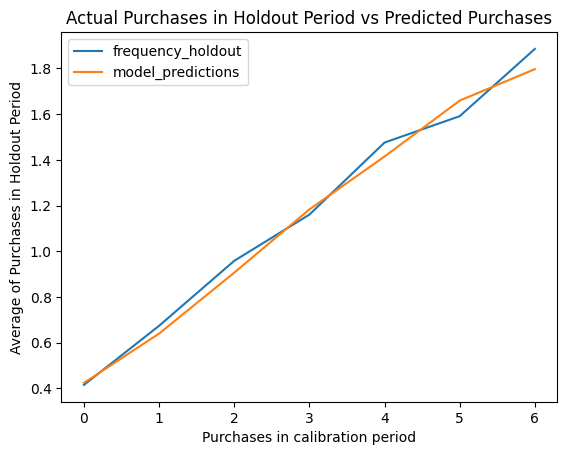

In [192]:
# Define time windows (same as Step 2)
obs_start   = pd.Timestamp("2009-12-01")
cal_end     = pd.Timestamp("2011-06-30")   # end of observation/calibration window
holdout_end = pd.Timestamp("2011-12-09")   # end of holdout window (end of data)
freq_unit   = "W"                          # weeks (stabil)

# Filter overall date range we care about
df_model = df[(df["InvoiceDate"] >= obs_start) & (df["InvoiceDate"] <= holdout_end)].copy()

# Build calibration + holdout summary table
summary_cal_holdout = calibration_and_holdout_data(
    transactions=df_model,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    calibration_period_end=cal_end,
    observation_period_end=holdout_end,
    freq=freq_unit
)

display(summary_cal_holdout.head())

# Fit BG/NBD on calibration data only
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(
    frequency=summary_cal_holdout["frequency_cal"],
    recency=summary_cal_holdout["recency_cal"],
    T=summary_cal_holdout["T_cal"]
)

print(bgf.summary)

# Quick sanity check: calibration vs holdout (aggregate-level)
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Predict expected purchases during holdout window (customer-level)
summary_cal_holdout["pred_purchases_holdout"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t=summary_cal_holdout["duration_holdout"],
    frequency=summary_cal_holdout["frequency_cal"],
    recency=summary_cal_holdout["recency_cal"],
    T=summary_cal_holdout["T_cal"]
)

# Simple evaluation metric (MAE) on holdout purchases
mae = np.mean(np.abs(summary_cal_holdout["pred_purchases_holdout"] - summary_cal_holdout["frequency_holdout"]))
print(f"Holdout MAE (purchases): {mae:.4f}")